#### Aspectos formales de los árboles de decisión
La exposición formal sobre los árboles de decisión se basa en Shalev-Shwartz, S y Ben-David,
S. 2014. Understanding Machine Learning: From Theory to Algorithms. Capítulo 18: Decision
Trees, y Hastie, T; Tibshirani, R y Friedman, J. 2009. The Elements of Statistical Learning:
Data Mining, Inference, and Prediction. Springer Series in Statistics. Springer. Ch9: Additive
Models, Trees, and Related Methods. 9.2: Tree-Based Methods.

Los árboles de decisión son métodos con forma funcional 𝑓(𝑥): 𝑋 → 𝑦 que permiten predecir
una clase asociada y con una instancia específica 𝑥 al recorrer desde un nodo principal
hasta una hoja (o nodo terminal). El objetivo de los árboles de decisión es encontrar una
serie de reglas de división del espacio muestral que optimicen la decisión local. En cada
nodo se busca resolver la siguiente función:

$$ \hat f(x) = \sum_{n = 1}^{s} c_mI (X_1, X_2) \in R_m $$

Donde 𝑅 es la región m producto de la partición definido en el espacio de atributos 𝑚
𝑅𝑚 ∋ (𝑋1, 𝑋2) .
𝑐 es el promedio del vector objetivo en la región. El objetivo es dado una partición del 𝑚
espacio de atributos, encontrar un puntaje de corte (denominado s) que asigne una nueva
observación a una de las dos regiones.

$$ R_1(j, s) = \{ X|X_j \leq s\} \hspace*{1em} ó \hspace*{1em} R_2(j, s) = \{ X|X_j \geq s\} $$

Para encontrar el puntaje de corte s en el espacio de atributos, es necesario optimizar por
algún criterio. En este caso trabajaremos con un árbol de regresión donde el vector objetivo
es contínuo.

$$ argmin_{j, s} \left[ argmin_{j, s} \sum_{x_1 \in R} (y_i - C_1)^2 + argmin_{j, s} \sum_{x_1 \in R} (y_i - C_2)^2 \right] $$

Donde $C_1$ y $C_2$ hacen referencia al promedio específico del vector objetivo en el espacio a dividir

$$ \hat c_1 = promedio(y_i|X_i \in R_1(j, s)) y  \hat c_2 = promedio(y_i|X_i \in R_2(j, s))$$ 

El proceso se itera hasta que las particiones realizadas en cada espacio de atributos no
sean informativas. Esto se conoce como pureza de la partición. Para el caso de los árboles
de regresión, el criterio para implementar es el error cuadrático promedio, que cuantifica la
contribución en la reducción de la varianza de determinado atributo. Posteriormente
trabajaremos con árboles de clasificación que implementan otros criterios de optimización.

#### Árboles de Regresión: Analizando los precios del mercado inmobiliario en California

Para ejemplificar cómo funcionan los árboles de decisión, utilizaremos una base de datos
sobre precios de inmuebles en California. La fuente de los datos proviene de Pace, K and
Barry, R. 1997. Sparse Spatial Autoregressions. Statistics and Probability Letters. 33: 291-297.
El objetivo es generar predicciones del precio de los inmuebles en California, dado su
posición geográfica (Longitud y Latitud), cantidad de piezas, el ingreso promedio de la zona,
población, cantidad de casas y el año de la casa. Partamos por preparar nuestro ambiente
de trabajo.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor

import lec7_graphs as afx

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
df = pd.read_csv('Datasets/cadata.csv', header = 1).drop(columns = '1')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MedianHouseValue  20640 non-null  float64
 1   MedianIncome      20640 non-null  float64
 2   MedianHouseAge    20640 non-null  float64
 3   TotalRooms        20640 non-null  float64
 4   TotalBedrooms     20640 non-null  float64
 5   Population        20640 non-null  float64
 6   Households        20640 non-null  float64
 7   Latitude          20640 non-null  float64
 8   Longitude         20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


Como siempre, un primer paso es ver cómo se comportan las variables. Para este ejemplo,
todas las variables son numéricas y punto flotante, por lo que podremos realizar un gráfico
de densidad.

In [3]:
df.sample(2, random_state = 15820)

,MedianHouseValue,MedianIncome,MedianHouseAge,TotalRooms,TotalBedrooms,Population,Households,Latitude,Longitude
6637,153500.0,2.5750,39.0,2776.0,840.0,2546.0,773.0,34.16,-118.14
9831,313900.0,3.5147,28.0,3983.0,852.0,1582.0,778.0,36.63,-121.93


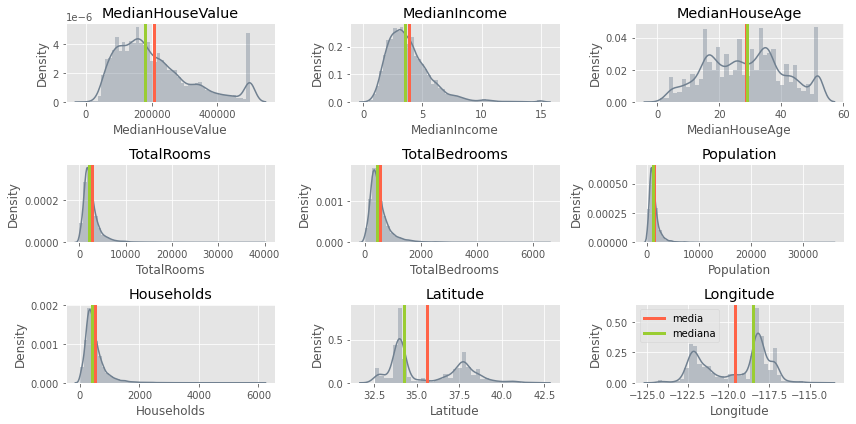

In [4]:
rows, cols = df.shape
cols = np.sqrt(cols)

plt.figure(figsize=(12, 6))
for index, (colname, serie) in enumerate(df.iteritems()):
        plt.subplot(int(cols), int(cols), index + 1)
        sns.distplot(serie, color = 'slategrey')
        plt.axvline(np.mean(serie), color = 'tomato', label = "media", lw=3)
        plt.axvline(np.median(serie), color = 'yellowgreen', label = 'mediana',lw=3)
        plt.title(colname)
plt.tight_layout()
plt.legend()


Mediante la inspección visual de los datos, nos percatamos que hay dos variables
candidatas para transformarlas con logaritmo. La primera es nuestra variable objetivo
MedianHouseValue y la segunda es MedianIncome, la cual representa el ingreso mediano del
sector donde se encuentra la casa.

Observamos que Latitude y Longitude presentan una distribución empírica con dos
cúspides. Cabe destacar que mientras la latitud presenta una cúspide más pronunciada en
los valores bajo la media, la longitud presenta una cúspide más pronunciada en los valores
sobre la media.

Resulta que ambas nos permiten realizar un mapeo sobre cómo se distribuyen los precios
del mercado inmobiliario en California. El gráfico demuestra que hay dos núcleos que
concentran los mayores precios de inmuebles (con colores rojos más pronunciados). Estos
corresponden al Bay Area (que incluyen ciudades como San Francisco, Palo Alto y San
José), y a Los Ángeles.


Text(0.5, 1.0, 'Observaciones registradas')

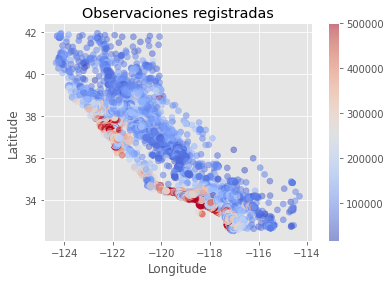

In [5]:
plt.scatter(df['Longitude'], df['Latitude'], c = df['MedianHouseValue'], cmap = 'coolwarm', alpha = .5)
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Observaciones registradas')

#### Nuestro primer árbol de regresión
Con nuestros datos inspeccionados, podemos comenzar a preparar nuestro análisis. Para
montar nuestro primer modelo, simplemente incorporaremos todos atributos en el modelo.
Debemos realizar los siguientes pasos:

1. Transformar los atributos MedianHouseValue y MedianIncome con el logaritmo.
2. Eliminar los atributos repetidos en la matriz de atributos.
3. Generar conjuntos de entrenamiento y validación.

In [6]:
# Vamos a trabajar con el logaritmo del vector para reducir no linealidad
df['log_MedianHouseValue'] = np.log(df['MedianHouseValue'])
# Sobreescribimos medianincome a log(medianincome)
df['log_MedianIncome'] = np.log(df['MedianIncome'])
# Definimos nuestro vector objetivo
y = df['log_MedianHouseValue']
# Definimos nuestra matriz de atributos y eliminamos irrelevantes
X = df.drop(columns=['MedianHouseValue', 'log_MedianHouseValue',
'MedianIncome'])
# Generamos muestras de entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 15820)

Para implementar nuestro árbol de regresión, necesitamos incorporar la clase
DecisionTreeRegressor del módulo tree disponible en la librería sklearn. Como todo
modelo de sklearn, los pasos para ejecutarlo son instanciar, ejecutar y contrastar el modelo
siguiendo métricas. Dado que nuestro vector objetivo es contínuo, implementaremos las
métricas más comunes como el error cuadrático promedio (mean_squared_error), la
mediana del error absoluto (median_absolute_error), y el coeficiente de determinación
(r2_score).

In [7]:
# Implementamos nuestro modelo sin modificar hiperparametros
dec_tree = DecisionTreeRegressor().fit(X_train, y_train)

In [8]:
y_hat = dec_tree.predict(X_test)
y_hat[:5]

array([12.02455077, 12.49874226, 11.97477091, 11.54829261, 10.91508846])

In [9]:
print(f'''Metricas 
Test MSE: {mean_squared_error(y_test, y_hat).round(5)}
Test MAE: {median_absolute_error(y_test, y_hat).round(5)}
Test R2:  {r2_score(y_test, y_hat).round(5)}''')

Metricas 
Test MSE: 0.10979
Test MAE: 0.15751
Test R2:  0.65418


Con nuestro modelo ejecutado, comparamos las métricas. Tanto el error cuadrático
promedio como la mediana del error absoluto sugieren que nuestro modelo erra en
aproximadamente .10 puntos en la escala logarítmica de nuestro vector objetivo. El
coeficiente de determinación sugiere que hay un 67% de variabilidad en nuestro vector
objetivo en la muestra de validación que se explica por los parámetros entrenados en
nuestra muestra de validación. Si bien el desempeño del modelo es relativamente aceptable,
hay márgen substancial para mejoras. Como todo modelo de aprendizaje de máquinas,
cuando queremos mejorar la capacidad predictiva, comenzamos a ajustar los
hiperparámetros.

### Hiperparámetros en los árboles de decisión

Los hiperparámetros a modificar en los árboles de decisión están asociados con las
siguientes preguntas:

- ¿Hasta qué punto puedo dejar crecer un árbol?
- ¿Cuántos datos son suficientes en cada nodo para particionar o declararlo terminal?
- ¿Cuántos atributos son suficientes para que mi árbol pueda capturar de buena manera el fenómeno?

Otro aspecto a considerar y que visitaremos posteriormente, es el hecho que éstos
hiperparámetros son idénticos si estamos hablando de un problema de regresión o
clasificación. Para visualizar las particiones en el espacio, restringiremos el ejercicio a los
atributos Longitud y Latitud, dado que permiten mapear de forma directa la división de áreas
de la región de California.

#### Máximo de profundidad

Ya sabemos que un árbol puede crecer de manera indefinida hasta que todos los nodos
sean puros. En este escenario es más que probable que terminemos con un modelo muy
bien ajustado a los datos de entrenamiento, que falla en poder ser generalizado a nuevas
instancias. Este problema de overfitting se puede solucionar mediante la limitación de qué
tan profundo puede ser un árbol.

En la implementación de sklearn, el hiperparámetro de profundidad de los nodos se
controla con 'max_depth'. Si bien no hay reglas específicas sobre un rango de máxima
profundidad, sabemos que debe partir en 1 dado que ésta es la partición mínima posible. El
rango de término puede ir desde 10 hasta arriba. En la figura generada como
afx.train_test_over_params evaluamos el error cuadrático promedio del modelo en las
muestras de entrenamiento y validación.

Hay un par de comportamientos a destacar:

- En la medida que la profundidad máxima se torna más permisiva, el error cuadrático
  promedio en la muestra de entrenamiento se acerca a cero. Esta es una situación de
  overfitting.
- La curva del modelo en el testing set se estanca cuando la profundidad máxima del
  árbol es aproximadamente igual a 10. Este parece ser un buen hiperparámetro a
  incorporar.


In [10]:
df = df.astype(int)
df.sample(5, random_state = 15820)

,MedianHouseValue,MedianIncome,MedianHouseAge,TotalRooms,TotalBedrooms,Population,Households,Latitude,Longitude,log_MedianHouseValue,log_MedianIncome
6637,153500,2,39,2776,840,2546,773,34,-118,11,0
9831,313900,3,28,3983,852,1582,778,36,-121,12,1
5992,154200,4,26,2744,494,1411,465,34,-117,11,1
7477,121000,2,36,1337,382,1769,393,33,-118,11,0
4494,109100,2,52,470,115,434,123,34,-118,11,0


In [11]:
# generamos subconjuntos específicos para el problema de dos atributos
x_tr, x_te, y_tr, y_te = train_test_split(df.loc[:, ['Longitude', 'Latitude']], df['log_MedianHouseValue'], test_size = .33, random_state = 15820)

In [12]:
y_te

6637     11
9831     12
5992     11
7477     11
4494     11
         ..
5045     11
14087    12
6285     12
5556     12
2310     12
Name: log_MedianHouseValue, Length: 6812, dtype: int32

In [13]:
# simulamos el desempeño en el rango del hiperparámetro
afx.train_test_over_params(DecisionTreeRegressor(), {'max_depth': np.linspace(1, 32, 32)}, x_tr, x_te, y_tr, y_te)
plt.xlabel('Cantidad de particiones')
plt.ylabel('Error Cuadrático Promedio')

TypeError: max_depth must be an instance of int, not float64.